In [35]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math


# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
import pyleoclim as pyleo
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

## Using sea surface height to calculate geostrophic velocity at the sea surface

## 2) Surface Geostrophy and Thermal Wind in the North Atlantic

The cartoon below shows a zonal cross section across the North Atlantic passing through the Gulf Stream and the subtropical gyre. This SSH pattern is qualitatively similar to the real SSH pattern off the Eastern US.


![North Atlantic](Figures/north_atlantic.png)


### 2b) Using surface geostrophic balance, estimate the speed of the meridional surface current in each of the two regions.

Use the following parameters: $L_1 = 500 km$, $L_2 = 3000 km$, $\eta_{max} = 0.5$  m.

$$
v = \frac{g}{f}\frac{\partial \eta}{\partial x}
$$

$$
u = -\frac{g}{f}\frac{\partial \eta}{\partial y}
$$

In [59]:
L1 = 500e3
L2 = 3000e3
f = gsw.f(26)
g = 9.8
dn = 0.5
v1_geo_surface = g/f * dn/L1
v2_geo_surface = g/f * -dn/L2
V = "%0.2f" % v1_geo_surface
U = "%0.3f" % v2_geo_surface
print('V = ' + V + ' m/s')
print('V2 = ' + U + ' m/s')
#v_geo_surface = 9.8/gsw.f(26) * 0.5/3000e3
#v_geo_surface

V = 0.15 m/s
V2 = -0.026 m/s


## The dynamic method for computing geostrophic shear
Now, let's use a hydrographic section to compute the geostrophic shear beneath this idealized sea surface slope.
At the website for [CLIVAR and Carbon Hydrographic Data Office](https://cchdo.ucsd.edu/) you can find hydrographic data taken all across the worlds ocean.  I have chosen zonal section A05 along 24N across the North Atlantic for the following demonstration of the dynamic method.


In [32]:
#load packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import fsspec
import gsw

In [33]:
#load the data
url_hydrosection = "https://cchdo.ucsd.edu/data/39135/740H20200119_bottle.nc" #using bottle file because file is smaller (recommend CTD)
ds = xr.open_dataset(fsspec.open(url_hydrosection).open(), decode_times=False)

In [41]:
# Extract the relevant variables from the dataset and calculate the needed derived variables
P = ds['pressure']  
SA = gsw.SA_from_SP(ds['ctd_salinity'], P, ds['longitude'], ds['latitude'])
CT = gsw.CT_from_t(SA, ds['ctd_temperature'], P)
sigma_theta = gsw.pot_rho_t_exact(SA, ds['ctd_temperature'], P, 0)

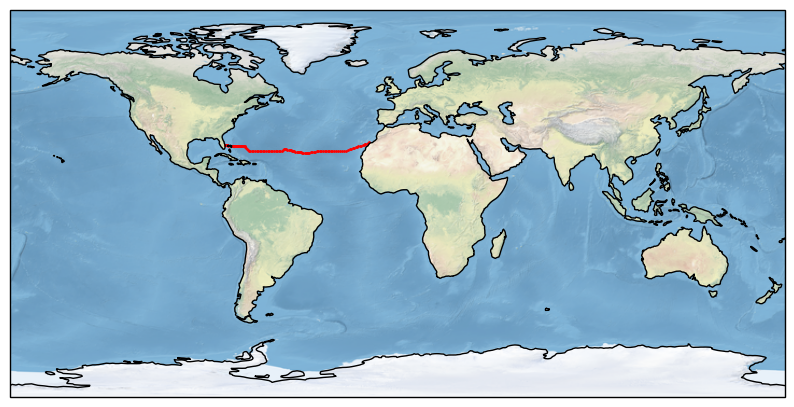

In [40]:
#Plot the station locations just to look where we are in detail
fig, ax = plt.subplots(figsize=[10,10], subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.stock_img()
ax.scatter(ds.longitude,ds.latitude, color = 'red', s = 1)

(134, 24)


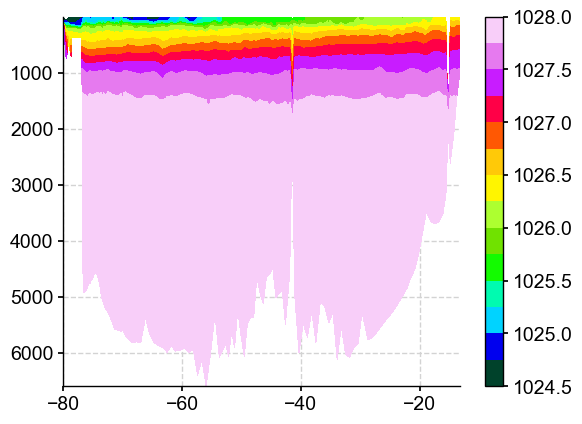

In [63]:
import matplotlib

P_grid, longitude_grid,= np.meshgrid( P[30,:],ds.longitude)
print(longitude_grid.shape)
contour_levels = np.arange(1024.5, 1028.25, 0.25)
plt.contourf(longitude_grid, P, sigma_theta, levels=contour_levels,cmap = 'gist_ncar')
# plt.pcolormesh(longitude_grid, P, sigma_theta, cmap = 'plasma_r')
plt.colorbar()
plt.gca().invert_yaxis()
# Plot black dots where P is a number (e.g., P != 0)
# Use np.where to get the positions where P meets the condition
x_positions, y_positions = np.where(P != 0)

# Find positions where P is not NaN
valid_positions = np.logical_not(np.isnan(P))

# Extract the longitude and P values where P is valid
x_positions = longitude_grid[valid_positions]  # Longitude for valid x-axis positions
y_positions = P_grid[valid_positions]          # P for valid y-axis positions

# Overlay the black dots on top of the pcolormesh plot
# plt.scatter(x_positions, y_positions, color='black', s=1, zorder=3)


In [64]:
# Extract the profiles in the west and east in deep water, and approximately the same latitude 
#(I used trial and error to find profile 31 and 11 from the end are good)
Wlon = ds['longitude'].values[30]  # 31st profile (index 30 in Python)
Elon = ds['longitude'].values[-10]  # 11th from end  profile
Wlat = ds['latitude'].values[30]
Elat = ds['latitude'].values[-10]
Wlon, Elon, Wlat, Elat

(-75.5065, -18.16598, 26.49672, 26.38353)

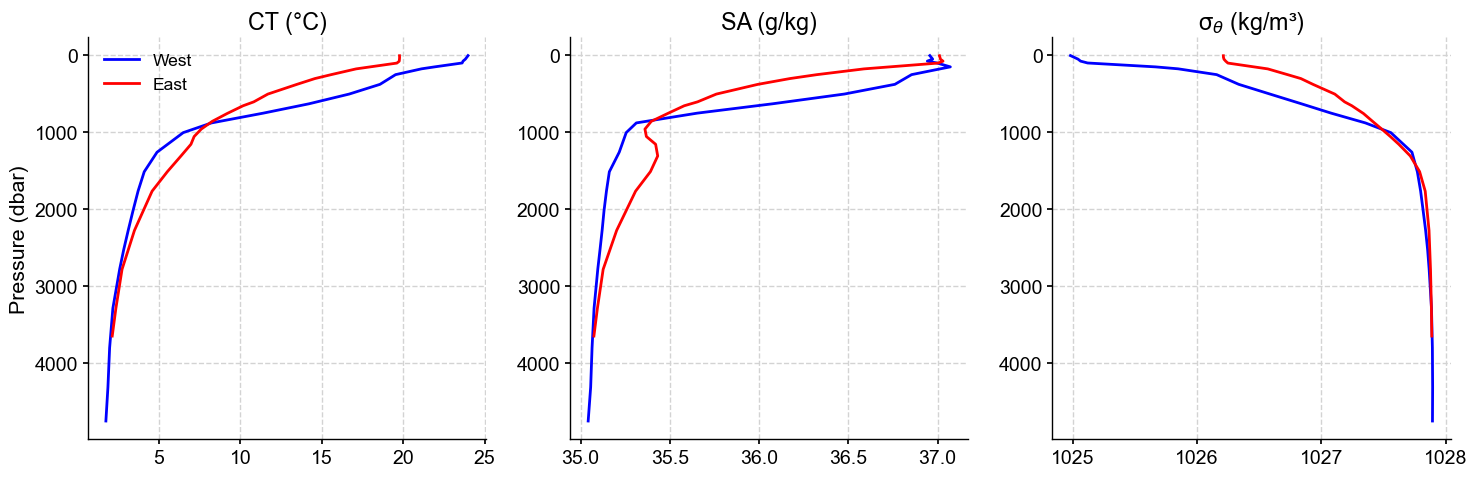

In [66]:

# Plot CT, SA, and sigma_theta
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot CT

axes[0].plot(CT[30, :], P[30, :], 'b', label = 'West')  # 10th profile (index 9)
axes[0].plot(CT[-10, :], P[-10, :], 'r',label = 'East')  # second-to-last profile
axes[0].invert_yaxis()
axes[0].set_ylabel('Pressure (dbar)')
axes[0].set_title('CT (°C)')
axes[0].legend()

# # # Plot SA
axes[1].plot(SA[30,:], P[30,:], 'b')
axes[1].plot(SA[-10,:], P[-10,:], 'r')
axes[1].invert_yaxis()
axes[1].set_title('SA (g/kg)')

# # # Plot sigma_theta
axes[2].plot(sigma_theta[30,:], P[30,:], 'b')
axes[2].plot(sigma_theta[-10,:], P[-10,:], 'r')
axes[2].invert_yaxis()
axes[2].set_title('σ$_θ$ (kg/m³)')

plt.tight_layout()
plt.show()


In [67]:
# Calculate the dynamic height for the western and eastern stations
dyn_height_west = gsw.geo_strf_dyn_height(SA[30,:], CT[30,:], P[30,:], 0)
dyn_height_east= gsw.geo_strf_dyn_height(SA[-10,:], CT[-10,:], P[-10,:], 0)

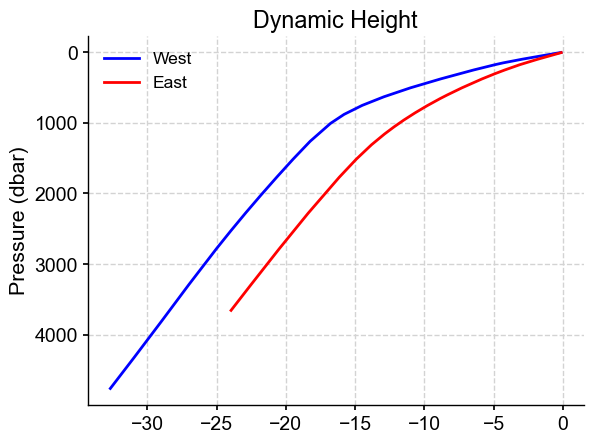

In [68]:
# Plot dynamic height
plt.figure()
plt.plot(dyn_height_west, P[30,:], 'b',label = 'West')
plt.plot(dyn_height_east, P[-10,:], 'r',label = 'East')
plt.gca().invert_yaxis()
plt.title('Dynamic Height')
plt.ylabel('Pressure (dbar)')
plt.legend()

$\dfrac{\partial v}{\partial z} = -\dfrac{1}{f}\dfrac{\partial D}{\partial x}$

In [462]:
# Calculate the geostrophic velocity at 1000 dbar, relative to the sea surface
# First, interpolate dynamic height to 1000 dbar
dhwest_1000 = np.interp(1000, P[30,~np.isnan(dyn_height_west)], dyn_height_west[~np.isnan(dyn_height_west)])
dheast_1000 = np.interp(1000, P[-10,~np.isnan(dyn_height_east)], dyn_height_east[~np.isnan(dyn_height_east)])

geostrophic_velocity, mid_lat, mid_long = gsw.geostrophic_velocity(
    [dhwest_1000, dheast_1000], [Wlon, Elon], [Wlat, Elat], 1000)
geostrophic_velocity

array([0.01347008])

In [95]:
help(gsw.geo_strf_dyn_height)

Help on function geo_strf_dyn_height in module gsw.geostrophy:

geo_strf_dyn_height(SA, CT, p, p_ref=0, axis=0, max_dp=1.0, interp_method='pchip')
    Dynamic height anomaly as a function of pressure.
    
    Parameters
    ----------
    SA : array-like
        Absolute Salinity, g/kg
    CT : array-like
        Conservative Temperature (ITS-90), degrees C
    p : array-like
        Sea pressure (absolute pressure minus 10.1325 dbar), dbar
    p_ref : float or array-like, optional
        Reference pressure, dbar
    axis : int, optional, default is 0
        The index of the pressure dimension in SA and CT.
    max_dp : float
        If any pressure interval in the input p exceeds max_dp, the dynamic
        height will be calculated after interpolating to a grid with this
        spacing.
    interp_method : string {'pchip', 'linear'}
        Interpolation algorithm.
    
    Returns
    -------
    dynamic_height : array
        This is the integral of specific volume anomaly with

Text(0.5, 1.0, 'Vertical Shear')

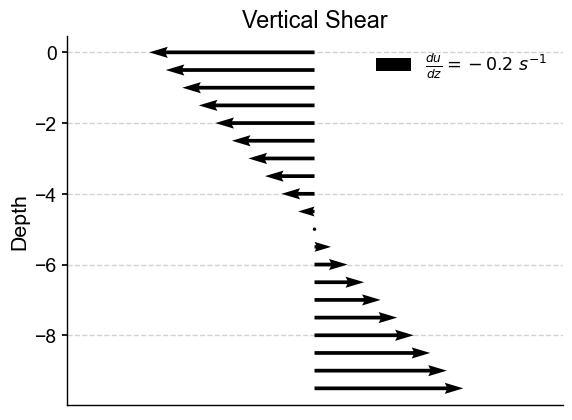

In [94]:
u = np.arange(-1,1,0.1)
v = np.zeros(len(u))
z = -np.arange(0,10,0.5)
x = np.zeros(len(u))
plt.quiver(x,z,u,v, scale = 3, label = r'$\frac{du}{dz} = -0.2\ s^{-1}$')
plt.legend()
plt.xticks([])
plt.ylabel('Depth')
plt.title('Vertical Shear')

In [90]:
np.diff(u)/np.diff(z)

array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2])

# What does this mean??